## 문제

* 반도체 제조 공정 중 A공정의 설비는 제어 인자가 6가지입니다. 
설비의 제어 인자를 변경하여, 제품을 원하는 target 값에 맞게 생산하고자 합니다. 
* 제품 종류에 따라 원하는 target의 값이 다릅니다.
* 제어 인자를 변경하여 원하는 target값이 나오는지 실험을 하기 위해서는 1회에 수 백 만원의 비용이 발생합니다.
* 제어 인자 조절에 따른 Target 값을 정확히 예측 할 수 있다면 이 비용을 절감 할 수 있습니다.
*주어진 X0,X1,X2,X3,X4,X5 값을 Feature로 target 값을 예측하는 모델을 만들어 보십시오.



In [17]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 58 kB/s 


In [68]:
import pandas as pd 
import numpy as np
import datetime as dt 
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense,LSTM, Attention,Bidirectional,MultiHeadAttention,Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import matplotlib.pyplot as plt 
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as xp
import plotly.subplots as sp
tf.test.gpu_device_name()

''

In [106]:
train = pd.read_csv("/content/drive/MyDrive/MNC채용/data/train (3).csv")
test = pd.read_csv("/content/drive/MyDrive/MNC채용/data/test (2).csv")

## 결측치, 이상치 확인

In [234]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      1500 non-null   float64
 1   X1      1500 non-null   int64  
 2   X2      1500 non-null   float64
 3   X3      1500 non-null   float64
 4   X4      1500 non-null   float64
 5   X5      1500 non-null   float64
 6   target  1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


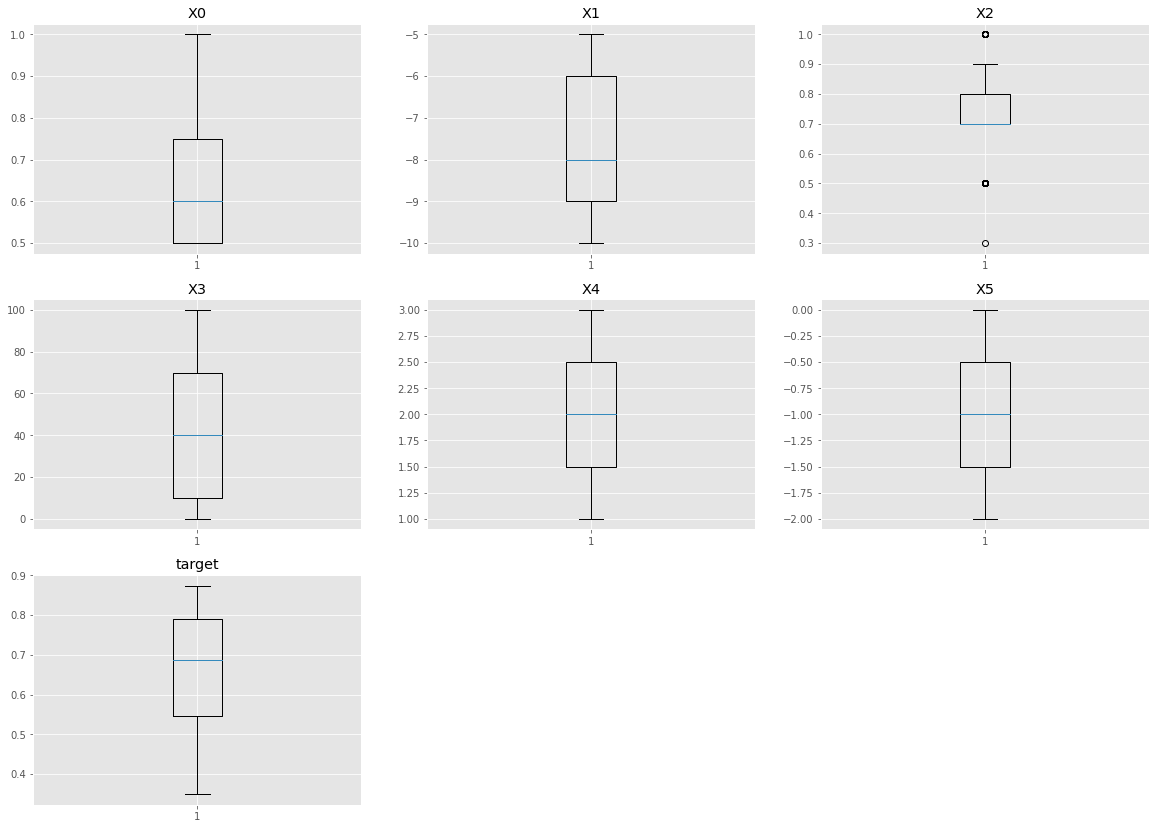

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

#Id컬럼은 제거
feature = train.columns[:]
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(12,3,i+1)
    plt.title(feature[i])
    plt.boxplot(train[feature[i]])
plt.show()

## 분포 확인하기

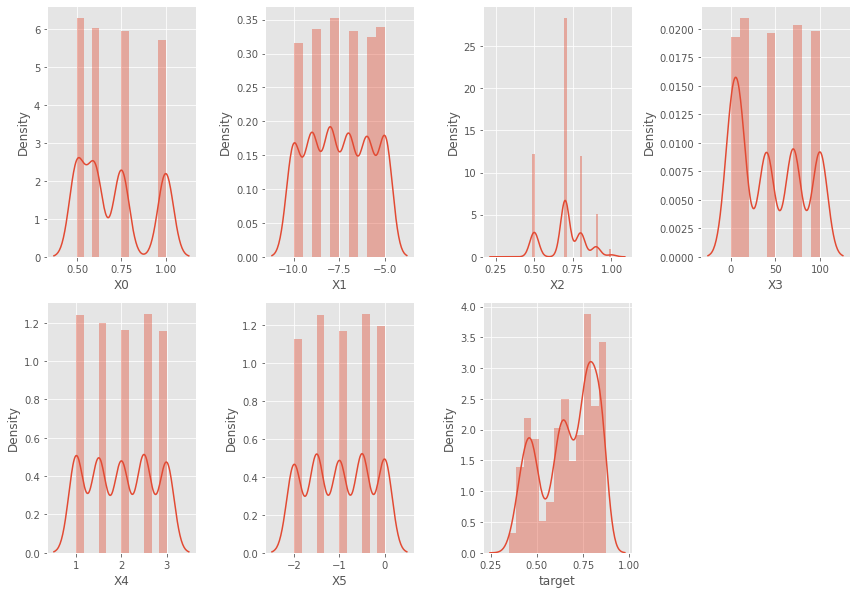

In [238]:
# 경고 메시지 숨기기
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 숫자형 변수의 각 변수별 분포를 살펴봅니다.
plt.figure(figsize=(12, 12))
for i, colName in enumerate(train.columns):
    plt.subplot(3, 4, i+1)
    sns.distplot(train.loc[:, colName])
plt.tight_layout()
plt.show()

In [107]:
print(train["X0"].value_counts())
print(train["X1"].value_counts())
print(train["X2"].value_counts())
print(train["X3"].value_counts())
print(train["X4"].value_counts())
print(train["X5"].value_counts())

0.50    393
0.60    377
0.75    372
1.00    358
Name: X0, dtype: int64
-8     264
-5     254
-9     252
-7     250
-6     243
-10    237
Name: X1, dtype: int64
0.7    725
0.5    314
0.8    306
0.9    129
1.0     25
0.3      1
Name: X2, dtype: int64
10.000     314
70.000     305
100.000    297
40.000     295
0.000      276
0.001       13
Name: X3, dtype: int64
2.5    311
1.0    310
1.5    300
2.0    290
3.0    289
Name: X4, dtype: int64
-0.5    314
-1.5    313
 0.0    299
-1.0    292
-2.0    282
Name: X5, dtype: int64


In [108]:
print(test["X0"].value_counts())
print(test["X1"].value_counts())
print(test["X2"].value_counts())
print(test["X3"].value_counts())
print(test["X4"].value_counts())
print(test["X5"].value_counts())

1.00    392
0.75    378
0.60    373
0.50    357
Name: X0, dtype: int64
-10    263
-6     257
-7     250
-9     248
-5     246
-8     236
Name: X1, dtype: int64
0.7    740
0.5    301
0.8    297
0.9    121
1.0     39
0.3      2
Name: X2, dtype: int64
40.000     305
100.000    303
0.000      300
70.000     295
10.000     286
0.001       11
Name: X3, dtype: int64
3.0    311
2.0    310
1.5    300
1.0    290
2.5    289
Name: X4, dtype: int64
-2.0    318
-1.0    308
 0.0    301
-1.5    287
-0.5    286
Name: X5, dtype: int64


In [109]:
# train["X2"] = train["X2"].replace(0.3,0.5)
# test["X2"] = test["X2"].replace(0.3,0.5)
# train["X2"] = train["X2"].replace(1.0,0.9)
# test["X2"] = test["X2"].replace(1.0,0.9)
# train["X3"] = train["X3"].replace(0.001,0)
# test["X3"] = test["X3"].replace(0.001,0)

## Feature Engineering
* 원-핫 인코딩

In [110]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train["X0"])
labels = encoder.transform(train["X0"])
encoder.fit(train["X1"])
labels1 = encoder.transform(train["X1"])
encoder.fit(train["X2"])
labels2 = encoder.transform(train["X2"])
encoder.fit(train["X3"])
labels3 = encoder.transform(train["X3"])
encoder.fit(train["X4"])
labels4 = encoder.transform(train["X4"])
encoder.fit(train["X5"])
labels5 = encoder.transform(train["X5"])

encoder2 = LabelEncoder()
encoder2.fit(test["X0"])
t_labels = encoder2.transform(test["X0"])
encoder2.fit(train["X1"])
t_labels1 = encoder2.transform(test["X1"])
encoder2.fit(train["X2"])
t_labels2 = encoder2.transform(test["X2"])
encoder2.fit(train["X3"])
t_labels3 = encoder2.transform(test["X3"])
encoder2.fit(train["X4"])
t_labels4 = encoder2.transform(test["X4"])
encoder2.fit(train["X5"])
t_labels5 = encoder2.transform(test["X5"])

labels = labels.reshape(-1,1)
labels1 = labels1.reshape(-1,1)
labels2 = labels2.reshape(-1,1)
labels3 = labels3.reshape(-1,1)
labels4 = labels4.reshape(-1,1)
labels5 = labels5.reshape(-1,1)
t_labels = t_labels.reshape(-1,1)
t_labels1 = t_labels1.reshape(-1,1)
t_labels2 = t_labels2.reshape(-1,1)
t_labels3 = t_labels3.reshape(-1,1)
t_labels4 = t_labels4.reshape(-1,1)
t_labels5 = t_labels5.reshape(-1,1)


ohe = OneHotEncoder()
X0 = ohe.fit_transform(labels)
X1 = ohe.fit_transform(labels1)
X2 = ohe.fit_transform(labels2)
X3 = ohe.fit_transform(labels3)
X4 = ohe.fit_transform(labels4)
X5 = ohe.fit_transform(labels5)

t_X0 = ohe.fit_transform(t_labels)
t_X1 = ohe.fit_transform(t_labels1)
t_X2 = ohe.fit_transform(t_labels2)
t_X3 = ohe.fit_transform(t_labels3)
t_X4 = ohe.fit_transform(t_labels4)
t_X5 = ohe.fit_transform(t_labels5)

In [113]:
temp = pd.DataFrame(X0.toarray(), columns=["X0_1", "X0_2", "X0_3", "X0_4"])
temp1 = pd.DataFrame(X1.toarray(), columns=["X1_1", "X1_2", "X1_3", "X1_4", "X1_5", "X1_6"])
temp2 = pd.DataFrame(X2.toarray(), columns=["X2_1", "X2_2", "X2_3", "X2_4","X2_5", "X2_6"])
temp3 = pd.DataFrame(X3.toarray(), columns=["X3_1", "X3_2", "X3_3", "X3_4", "X3_5", "X3_6"])
temp4 = pd.DataFrame(X4.toarray(), columns=["X4_1", "X4_2", "X4_3", "X4_4", "X4_5"])
temp5 = pd.DataFrame(X5.toarray(), columns=["X5_1", "X5_2", "X5_3", "X5_4", "X5_5"])

In [114]:
t_temp = pd.DataFrame(t_X0.toarray(), columns=["X0_1", "X0_2", "X0_3", "X0_4"])
t_temp1 = pd.DataFrame(t_X1.toarray(), columns=["X1_1", "X1_2", "X1_3", "X1_4", "X1_5", "X1_6"])
t_temp2 = pd.DataFrame(t_X2.toarray(), columns=["X2_1", "X2_2", "X2_3", "X2_4","X2_5", "X2_6"])
t_temp3 = pd.DataFrame(t_X3.toarray(), columns=["X3_1", "X3_2", "X3_3", "X3_4", "X3_5", "X3_6"])
t_temp4 = pd.DataFrame(t_X4.toarray(), columns=["X4_1", "X4_2", "X4_3", "X4_4", "X4_5"])
t_temp5 = pd.DataFrame(t_X5.toarray(), columns=["X5_1", "X5_2", "X5_3", "X5_4", "X5_5"])

In [115]:
dtrain = train.drop(["X0","X1","X2","X3","X4","X5"],axis=1)
target = test.drop(["X0","X1","X2","X3","X4","X5"],axis=1)
dtrain,target

(      target
 0     0.6441
 1     0.6236
 2     0.7069
 3     0.7764
 4     0.6493
 ...      ...
 1495  0.6014
 1496  0.4483
 1497  0.6757
 1498  0.6114
 1499  0.8338
 
 [1500 rows x 1 columns],       target
 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
 ...      ...
 1495     0.0
 1496     0.0
 1497     0.0
 1498     0.0
 1499     0.0
 
 [1500 rows x 1 columns])

In [116]:
train3 = pd.concat([temp,temp1,temp2,temp3,temp4,temp5,dtrain], axis=1)
test2 = pd.concat([t_temp,t_temp1,t_temp2,t_temp3,t_temp4,t_temp5,target], axis=1)
train3

,X0_1,X0_2,X0_3,X0_4,X1_1,X1_2,X1_3,X1_4,X1_5,X1_6,...,X4_2,X4_3,X4_4,X4_5,X5_1,X5_2,X5_3,X5_4,X5_5,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.6441
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.6236
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.7069
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7764
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.6493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6014
1496,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.4483
1497,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.6757
1498,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6114


In [117]:
test2

,X0_1,X0_2,X0_3,X0_4,X1_1,X1_2,X1_3,X1_4,X1_5,X1_6,...,X4_2,X4_3,X4_4,X4_5,X5_1,X5_2,X5_3,X5_4,X5_5,target
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1498,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [118]:
X = train3.drop('target', axis=1).astype("int")
y = train['target']

X_test = test2.drop("target", axis=1).astype("int")
X_test

,X0_1,X0_2,X0_3,X0_4,X1_1,X1_2,X1_3,X1_4,X1_5,X1_6,...,X4_1,X4_2,X4_3,X4_4,X4_5,X5_1,X5_2,X5_3,X5_4,X5_5
0,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1496,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1497,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1498,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


##Train Valid Split

In [119]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

## Model Test

In [120]:
def mae(x,y):
    return np.mean(np.abs(x-y))

In [121]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, ElasticNetCV

# scaler 가 없는 상태
model = LinearRegression() # 모델 선정
model.fit(X_train, y_train) # 모델 학습
pred = model.predict(X_valid)
mae(pred, y_valid)

0.017675684895833335

In [125]:
# 다른 모델을 구현해봅시다.
from lightgbm import LGBMRegressor
model = LGBMRegressor(learning_rate=0.22, n_estimators = 1500) # 모델 선정
model.fit(X_train, y_train) # 모델 학습
pred = model.predict(X_valid)
mae(pred, y_valid)

0.01480202165155242

In [126]:

# 다른 모델을 구현해봅시다.
from catboost import CatBoostRegressor
model2 =  CatBoostRegressor(learning_rate=0.25, iterations= 1500)
model2.fit(X_train, y_train) # 모델 학습
pred2 = model2.predict(X_valid)
mae(pred2, y_valid)

0:	learn: 0.1134610	total: 2.24ms	remaining: 3.37s
1:	learn: 0.0896884	total: 3.78ms	remaining: 2.83s
2:	learn: 0.0728292	total: 5.39ms	remaining: 2.69s
3:	learn: 0.0593585	total: 7.91ms	remaining: 2.96s
4:	learn: 0.0495412	total: 9.33ms	remaining: 2.79s
5:	learn: 0.0430421	total: 10.6ms	remaining: 2.63s
6:	learn: 0.0379890	total: 11.8ms	remaining: 2.51s
7:	learn: 0.0348559	total: 13.3ms	remaining: 2.48s
8:	learn: 0.0330429	total: 14.8ms	remaining: 2.45s
9:	learn: 0.0313825	total: 16.2ms	remaining: 2.41s
10:	learn: 0.0299262	total: 17.6ms	remaining: 2.39s
11:	learn: 0.0289161	total: 19.1ms	remaining: 2.37s
12:	learn: 0.0283569	total: 20.5ms	remaining: 2.35s
13:	learn: 0.0275358	total: 22.3ms	remaining: 2.36s
14:	learn: 0.0270169	total: 23.8ms	remaining: 2.35s
15:	learn: 0.0265391	total: 25.2ms	remaining: 2.34s
16:	learn: 0.0261546	total: 26.7ms	remaining: 2.33s
17:	learn: 0.0258304	total: 28.1ms	remaining: 2.32s
18:	learn: 0.0255665	total: 29.5ms	remaining: 2.3s
19:	learn: 0.0254174	to

0.013277915195298196

## Inference(최종 모델링)
* keras 사용

In [229]:
from tensorflow import keras
# from tensorflow.keras.layers import LSTM, Bidirectional
weight_decay = 1e-5
learning_rate = 0.0031

# build a simple FNN using keras
model = keras.Sequential([
    keras.layers.Dense(128, activation='tanh', input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(weight_decay)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.l2(weight_decay)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='tanh' ,kernel_regularizer=keras.regularizers.l2(weight_decay)),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dense(16, activation='tanh' ,kernel_regularizer=keras.regularizers.l2(weight_decay)),
    keras.layers.Dropout(0),
    keras.layers.Dense(10)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate) , loss='mae', metrics=['mae'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

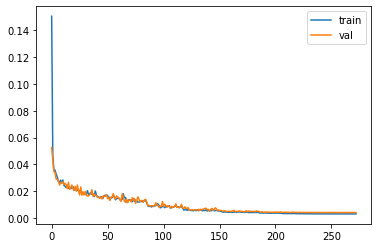

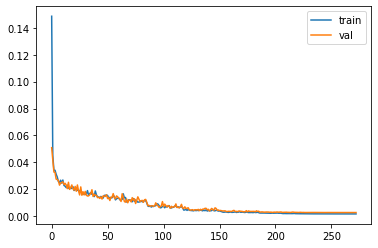

[0.0027249509003013372, 0.002706962637603283, 0.0027307334821671247, 0.0027051917277276516, 0.0027203639037907124, 0.002712460933253169, 0.0027228195685893297, 0.0027085135225206614, 0.0027025227900594473, 0.002703707432374358]


In [230]:
#LOSS
history = model.fit(X_train, y_train, validation_split=0.1, epochs=1200, batch_size=32, callbacks=[early_stopping, lr_scheduler], verbose=0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

#MAE
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.legend()
plt.show()
print(history.history['val_mae'][-30:-20])

In [231]:
y_pred = model.predict(X_test)
print(y_pred)
test["target"] = y_pred

[[0.40115365 0.40255368 0.4020453  ... 0.40305385 0.4026484  0.4054838 ]
 [0.58473593 0.58343804 0.5836508  ... 0.58387965 0.5844201  0.585386  ]
 [0.43039557 0.43039283 0.42929238 ... 0.42991805 0.43052858 0.42947465]
 ...
 [0.48803097 0.4915881  0.49427953 ... 0.49264556 0.4917572  0.48895696]
 [0.53983265 0.54143727 0.539632   ... 0.53932613 0.53933746 0.5396044 ]
 [0.5830017  0.5841036  0.5843563  ... 0.5812044  0.58462375 0.5825253 ]]


In [232]:
test

,X0,X1,X2,X3,X4,X5,target
0,1.00,-5,0.7,0.0,1.0,-0.5,0.401154
1,0.75,-7,0.7,40.0,1.0,-0.5,0.584736
2,1.00,-8,0.7,70.0,1.0,-1.0,0.430396
3,0.60,-6,0.9,70.0,1.5,-2.0,0.746819
4,1.00,-7,0.7,40.0,2.5,-1.5,0.489381
...,...,...,...,...,...,...,...
1495,1.00,-8,0.7,100.0,1.0,-0.5,0.453791
1496,0.60,-6,1.0,100.0,2.5,-2.0,0.740859
1497,1.00,-8,0.5,40.0,2.0,0.0,0.488031
1498,0.75,-6,0.7,0.0,1.0,-0.5,0.539833


In [233]:
test.to_csv('/content/drive/MyDrive/MNC채용/data2/keras_nn3.csv', index=False)